In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 312)

In [106]:
data = pd.read_csv('HR_data.csv').drop([104, 120, 122, 125, 272])
X_data = data[['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT',
       'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']]
feature_names = X_data.columns
y_string = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid', 'active' ]
y_data = data[y_string]


In [107]:
def encoding(X, y, type = 'ordinal'):
    X = X.copy()
    y = y.copy()
    if type == 'dummy':
        X = pd.get_dummies(X, columns=['Round', 'Phase', 'Individual', 'Cohort']).astype('int')
    elif type == 'ordinal':
        pass
        round_mapping = {'round_1': 1, 'round_2': 2, 'round_3': 3, 'round_4': 4}
        cohort_mapping = {'D1_1': 1, 'D1_2': 2, 'D1_3': 3, 'D1_4': 4, 'D1_5': 5, 'D1_6': 6}
        phase_mapping = {'phase1': 1, 'phase2': 2, 'phase3': 3}

        X['Round'] = X['Round'].map(round_mapping)
        X['Cohort'] = X['Cohort'].map(cohort_mapping)
        X['Phase'] = X['Phase'].map(phase_mapping)

    y['Frustrated'] = (y['Frustrated'] - 0.5)/10

    for col in y.columns:
        if col != 'Frustrated':
            y[col] = (y[col] - 0.5) / 6
            
    return X, y



In [108]:
def GridSearch_random_forest(param_grid, X, y):
    random_forest = RandomForestRegressor()
    grid_search = GridSearchCV(random_forest, param_grid, cv=10, n_jobs=-1)

    grid_search.fit(X, y)
    
    return grid_search.best_estimator_


In [109]:
def Nested_CV_GridSearch_random_forest(param_grid, X, y):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)

    best_params_list = []
    generalization_errors = []
    classification_errors = []

    X = X.values
    y = y.values

    for train_index, test_index in outer_cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        random_forest = RandomForestRegressor()

        grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=inner_cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_params_list.append(best_params)

        best_estimator = grid_search.best_estimator_
        y_pred = best_estimator.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        generalization_errors.append(mse)

        y_pred_cat = np.round(y_pred*6 + 0.5)
        y_test_cat = y_test*6 + 0.5
        acc = accuracy_score(y_test_cat, y_pred_cat)
        classification_errors.append(acc)

    return best_params_list, generalization_errors, classification_errors


In [110]:
emotion = 'ashamed'
X, y_enc = encoding(X_data, y_data)
y = y_enc[emotion]

param_grid_random_forest = {
    'n_estimators': np.arange(1, 200, 5),
    'max_depth': np.arange(1, 20, 2),
}

#best_params, gen_errors, class_errors = Nested_CV_GridSearch_random_forest(param_grid_random_forest, X, y)

best_params = [{'max_depth': 1, 'n_estimators': 21}, {'max_depth': 1, 'n_estimators': 31}, {'max_depth': 1, 'n_estimators': 21}, {'max_depth': 1, 'n_estimators': 11}, {'max_depth': 1, 'n_estimators': 46}, {'max_depth': 1, 'n_estimators': 131}, {'max_depth': 1, 'n_estimators': 71}, {'max_depth': 1, 'n_estimators': 51}, {'max_depth': 1, 'n_estimators': 51}, {'max_depth': 3, 'n_estimators': 1}]
gen_errors = [0.009801703706070907, 0.014574890753682056, 0.008321360006048663, 0.009518354447593082, 0.002824106751557281, 0.006551357000568088, 0.008887259409944689, 0.0154017499345745, 0.004563945449669974, 0.011582472495170913]
class_errors = [0.7741935483870968, 0.7419354838709677, 0.8064516129032258, 0.8709677419354839, 0.9032258064516129, 0.8387096774193549, 0.6774193548387096, 0.8, 0.8, 0.8]

In [111]:
print("Bedste parametre\n:", best_params)
print("Generaliseringsfejl\n:", gen_errors)
print("Accuracy\n:", class_errors)

Bedste parametre
: [{'max_depth': 1, 'n_estimators': 21}, {'max_depth': 1, 'n_estimators': 31}, {'max_depth': 1, 'n_estimators': 21}, {'max_depth': 1, 'n_estimators': 11}, {'max_depth': 1, 'n_estimators': 46}, {'max_depth': 1, 'n_estimators': 131}, {'max_depth': 1, 'n_estimators': 71}, {'max_depth': 1, 'n_estimators': 51}, {'max_depth': 1, 'n_estimators': 51}, {'max_depth': 3, 'n_estimators': 1}]
Generaliseringsfejl
: [0.009801703706070907, 0.014574890753682056, 0.008321360006048663, 0.009518354447593082, 0.002824106751557281, 0.006551357000568088, 0.008887259409944689, 0.0154017499345745, 0.004563945449669974, 0.011582472495170913]
Accuracy
: [0.7741935483870968, 0.7419354838709677, 0.8064516129032258, 0.8709677419354839, 0.9032258064516129, 0.8387096774193549, 0.6774193548387096, 0.8, 0.8, 0.8]


In [112]:
param_grid_random_forest = {
    'n_estimators': [30],  # Antal træer i skoven
    'max_depth': [1],  # Maksimal dybde af træerne i skoven

}

best_model_random_forest = GridSearch_random_forest(param_grid_random_forest, X, y)

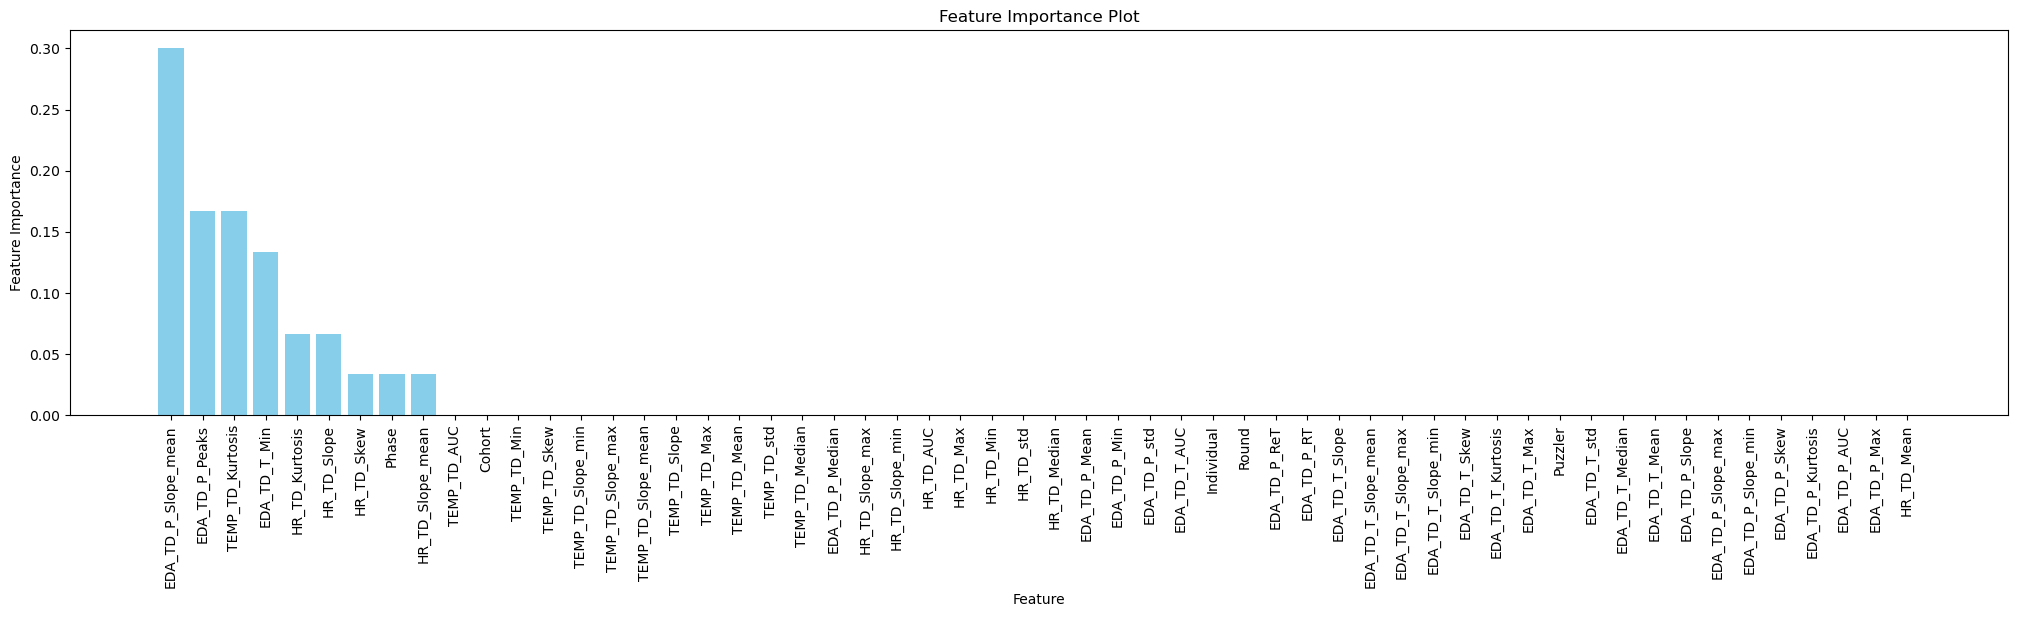

In [113]:
best_model_random_forest.fit(X, y)

importances = best_model_random_forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
features_sorted = feature_names[sorted_indices]

plt.figure(figsize=(25, 5))
plt.bar(np.arange(len(features_sorted)), sorted_importances, color='skyblue')
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.title(f'Feature Importance Plot')
plt.xticks(np.arange(len(features_sorted)), features_sorted, rotation=90) 
plt.show()

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
best_model_random_forest.fit(X_train, y_train)
best_model_random_forest.predict(X_test)

y_pred = best_model_random_forest.predict(X_test)
print(mean_squared_error(y_pred, y_test))
y_pred_cat = np.round(y_pred*6 + 0.5)
y_test_cat = y_test*6 + 0.5
# Beregn MAE
error = accuracy_score(y_test_cat, y_pred_cat)
print(error)

0.007814581830162738
0.7956989247311828
